In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np

import sys
sys.path.append('./../scripts')

from refuelplot import *
setup()
sns.set_style("white")

In [63]:
tx_path = '/data/projects/texas-power-outages/data/interim/'
fig_path = '/data/projects/texas-power-outages/data/figures/'
out_path = '/data/projects/texas-power-outages/data/output/'
fig_path_raw = fig_path+'raw_data/'

In [3]:
added_thermal_cap = 1.5

# load data

### load outages

In [4]:
reduction = pd.read_csv(tx_path+'outages/outages_reduction.csv',index_col='time',parse_dates=['time']).tz_localize(None).tz_localize('Etc/GMT+6')
reductionN = pd.read_csv(tx_path+'outages/outages_reductionNorth.csv',index_col='time',parse_dates=['time']).tz_localize(None).tz_localize('Etc/GMT+6')
reductionS = pd.read_csv(tx_path+'outages/outages_reductionSouth.csv',index_col='time',parse_dates=['time']).tz_localize(None).tz_localize('Etc/GMT+6')

In [5]:
reduction[['NG','WIND','COAL']].fillna(0).sum(axis=1).max()

41858.98333333334

In [6]:
reduction.index[reduction[['NG','WIND','COAL']].fillna(0).sum(axis=1)==reduction[['NG','WIND','COAL']].fillna(0).sum(axis=1).max()]

DatetimeIndex(['2021-02-16 07:00:00-06:00'], dtype='datetime64[ns, Etc/GMT+6]', name='time', freq=None)

### load load

In [10]:
load = pd.read_csv(tx_path + 'load/load_est_LR24temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

In [11]:
load70 = pd.read_csv(tx_path + 'load/load_est70_LR24_temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

### load windpower

In [13]:
# get wind power
wp = pd.read_csv(tx_path + 'windpower/wpTXh.csv',parse_dates=True,index_col=0).tz_localize('UTC').tz_convert('Etc/GMT+6').wp

### load temperature

In [14]:
# load temperature population indicator
tpxr = xr.open_mfdataset(tx_path + 'temperatures/temppop/temppop_????C.nc').__xarray_dataarray_variable__
tpxr.name= 'tp'
tp = tpxr.to_dataframe().tz_localize('UTC').tz_convert('Etc/GMT+6')
tpd = tp.resample('D').mean()

In [15]:
# load power plant temperatures
temppp = pd.read_csv(tx_path + 'temperatures/temppowerplant.csv',index_col=0,parse_dates=True).tz_localize('UTC').tz_convert('Etc/GMT+6')

In [16]:
# load gas field temperatures
tempgf = pd.read_csv(tx_path + 'temperatures/temp_gasfields.csv',index_col=0,parse_dates=True).t2m.tz_convert('Etc/GMT+6')

In [17]:
# get temperature at windparks
tempwp = pd.read_csv(tx_path + 'temperatures/tempWP.csv',parse_dates=True,index_col=0).tz_convert('Etc/GMT+6').t2m
tempwpNS = pd.read_csv(tx_path + 'temperatures/tempWP_NSsplit.csv',parse_dates=True,index_col=0).tz_convert('Etc/GMT+6')

### load outage model results

In [18]:
out_model_param = pd.read_csv(out_path + 'outage_function_parameters/outage_function_parameters.cvs',index_col=0)

### load threshold and forecast

In [21]:
# add 4.5GW to threshold to assume higher available thermal capacity
thresh_total = pd.read_csv(tx_path + 'thresholds/thresh_total.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')['0'] + added_thermal_cap
thresh_totalPP = pd.read_csv(tx_path + 'thresholds/thresh_totalPP.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')['0'] + added_thermal_cap

In [20]:
# load load forecast
fc = pd.read_csv('/data/projects/texas-power-outages/data/input/Load/load_forecast_ercot2.csv',parse_dates=True)
ampm = {'a.m.':0, 'p.m.':12}
fc.index = [pd.to_datetime(d[0]) + np.timedelta64(int(d[1])+ampm.get(d[2]),'h') for d in fc['Timestamp (Hour Ending)'].str.replace('12 a.m.','0 a.m.').str.replace('12 p.m.','12 a.m.').str.split(' ')]
fc = fc.tz_localize('Etc/GMT+6')

# plots

## plot outages + load + temp

In [22]:
out_wind = pd.concat([pd.Series(0,index=load70['2021-02':'2021-02-09 23'].index), reduction.WIND])
out_thermal = pd.concat([pd.Series(0,index=load70['2021-02':'2021-02-09 23'].index),reduction[['NG','COAL']].sum(axis=1)])
#out = pd.concat([out_wind,out_thermal,wp],axis=1)['2021-02'].fillna(0)
#out.columns = ['wind','thermal','wp']
remain = (62+added_thermal_cap - out_thermal/1000 + wp/10**6*(33-out_wind/1000)/33).dropna()

In [23]:
load.load_est['2021-02-16 07']/1000 - remain['2021-02-16 07']

27.933846793882594

In [24]:
dif = (load.load_est['2021-02']/1000 - remain['2021-02'])
dif[dif==dif.max()]

time
2021-02-15 20:00:00-06:00    31.85593
dtype: float64

In [25]:
(dif>0).sum()

108

In [26]:
dif[dif>0]

time
2021-02-15 00:00:00-06:00     0.170972
2021-02-15 01:00:00-06:00     2.477034
2021-02-15 02:00:00-06:00     7.381755
2021-02-15 03:00:00-06:00     8.401627
2021-02-15 04:00:00-06:00     8.844401
                               ...    
2021-02-19 07:00:00-06:00    13.416518
2021-02-19 08:00:00-06:00    11.511663
2021-02-19 09:00:00-06:00     6.483638
2021-02-19 10:00:00-06:00     4.591233
2021-02-19 11:00:00-06:00     1.277501
Length: 108, dtype: float64

In [27]:
reduction[['NG','WIND','COAL']].fillna(0).sum(axis=1)['2021-02-15 20']

39630.36666666667

In [28]:
(load.load_est - load.load)[(load.load_est - load.load)>0]['2021-02'].sum()/10**6

1.6927716053002448

#### plot

In [29]:
(load.load_est/1000 - thresh_totalPP)[(load.load_est/1000 - thresh_totalPP)>0]['2021-02'].sum()/1000

1.2536298409140836

In [70]:
x = reduction['2021-02-13':'2021-02-20'].index
data_eventFeb21 = pd.DataFrame({'load':load.load['2021-02-13':'2021-02-20 23']/1000,
                                'load_est':load.load_est['2021-02-13':'2021-02-20 23']/1000,
                                'thresh':thresh_totalPP['2021-02-13':'2021-02-20 23'],
                                'temp_population':tp.tp['2021-02-13':'2021-02-20'],
                                'temp_gaspowerplant':temppp.NG['2021-02-13':'2021-02-20'],
                                'temp_gasfield':tempgf['2021-02-13':'2021-02-20'],
                                'temp_coalpowerplant':temppp.COAL['2021-02-13':'2021-02-20'],
                                'temp_windparkNorth':tempwpNS.t2mNorth['2021-02-13':'2021-02-20'],
                                'temp_windparkSouth':tempwpNS.t2mSouth['2021-02-13':'2021-02-20'],
                                'outage_gas':reduction.NG[x]/1000,
                                'outage_coal':reduction.COAL[x]/1000,
                                'outage_wind':reduction.WIND[x]/1000,
                                'outage_other':reduction[['SOLAR','ESR','HYDRO','NUCLEAR']].sum(axis=1)[x]/1000})

In [72]:
data_eventFeb21.to_csv(fig_path_raw + 'Fig1.csv')

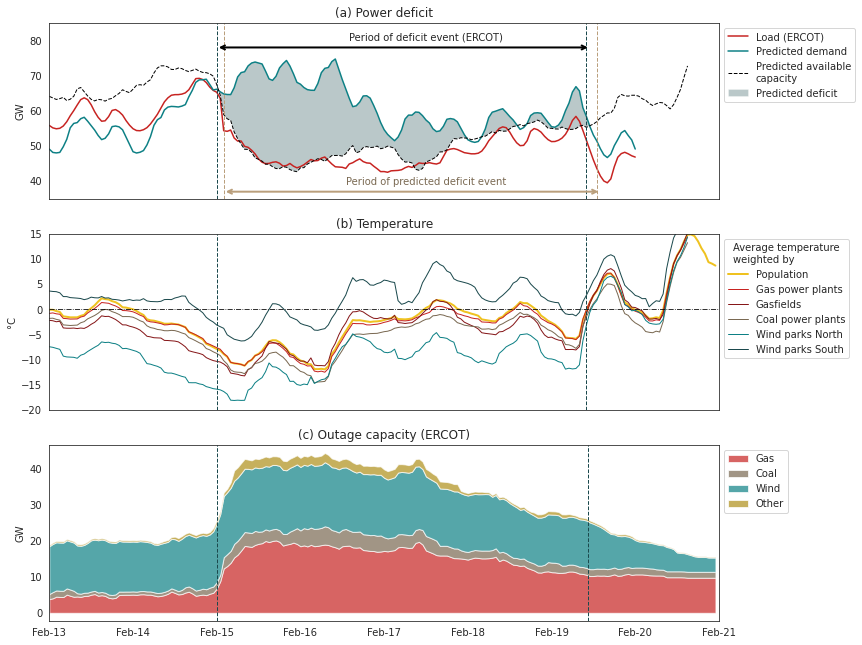

In [32]:
(fig,(ax1,ax2,ax3))=plt.subplots(3,1,figsize=(12,11))
fig.subplots_adjust(hspace = .2)

# POWER DEFICIT
(load.load['2021-02-13':'2021-02-20 23']/1000).plot(ax=ax1,label='Load (ERCOT)')
(load.load_est['2021-02-13':'2021-02-20 23']/1000).plot(ax=ax1,label='Predicted demand')
#(fc['Demand Forecast (MWh)']['2021-02-13':'2021-02-20 23']/1000).plot(ax=ax1,label='Load forecast')
#remain['2021-02-13':'2021-02-20 23'].plot(ax=ax1,label='Available capacity',color='black',style='--',lw=1)
thresh_totalPP['2021-02-13':'2021-02-20 23'].plot(ax=ax1,label='Predicted available\ncapacity',style='--',lw=1,color='black')
# fill
x = load.load_est['2021-02-13':'2021-02-19 13:30'].index
#y1 = load.load[x]/1000
y1 = thresh_totalPP[x]
y2 =load.load_est[x]/1000
ax1.fill_between(x,y1, y2, where=y1 <= y2,
                 facecolor=COLORS[4], interpolate=True,alpha=0.3,label='Predicted deficit')

ax1.set_ylabel('GW')
ax1.set_ylim((35,85))
lgd1=ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.set_xticklabels([])
tk = pd.Series(np.timedelta64(6,'h')*range(33)).apply(lambda x: pd.to_datetime('2021-02-13').tz_localize('Etc/GMT+6') + x)
ax1.set_xticks(tk.values,minor=True)
#ax1.set_xticks(tk[np.arange(0,33,4)].values,minor=False)
ax1.set_xticks((tk[np.arange(0,33,4)]-np.timedelta64(6,'h')).values,minor=False)
#ax1.grid(which='major',linewidth=1.5,axis='x')
#ax1.grid(which='minor',linewidth=0.5,axis='x')
ax1.set_xlabel('')
ax1.set_title('(a) Power deficit')

ax1.set_xlim((pd.to_datetime('2021-02-13').tz_localize('Etc/GMT+6'),pd.to_datetime('2021-02-21').tz_localize('Etc/GMT+6')))

# TEMPERATURES
tp.tp['2021-02-13':'2021-02-20'].plot(ax=ax2,linewidth=2,label='Population',color=COLORS[2])
temppp.NG['2021-02-13':'2021-02-20'].plot(ax=ax2,lw=1,label='Gas power plants',color=COLORS[0])
tempgf['2021-02-13':'2021-02-20'].plot(ax=ax2,lw=1,label='Gasfields',color=COLORS[5])
temppp.COAL['2021-02-13':'2021-02-20'].plot(ax=ax2,lw=1,label='Coal power plants',color=COLORS[7])
tempwpNS.t2mNorth['2021-02-13':'2021-02-20'].plot(ax=ax2,lw=1,label='Wind parks North',color=COLORS[1])
tempwpNS.t2mSouth['2021-02-13':'2021-02-20'].plot(ax=ax2,lw=1,label='Wind parks South',color=COLORS[4])

ax2.axhline(0,c='black',lw=0.8,ls='-.')
ax2.set_xticklabels([])
ax2.set_ylabel('°C')
ax2.set_ylim((-20,15))
ax2.set_xticks(tk.values,minor=True)
#ax2.set_xticks(tk[np.arange(0,33,4)].values,minor=False)
ax2.set_xticks((tk[np.arange(0,33,4)]-np.timedelta64(6,'h')).values,minor=False)
#ax2.grid(which='major',linewidth=1.5,axis='x')
#ax2.grid(which='minor',linewidth=0.5,axis='x')
ax2.set_xlabel('')
ax2.set_title('(b) Temperature')
lgd2=ax2.legend(bbox_to_anchor=(1, 1), loc='upper left',title='Average temperature\nweighted by')

ax2.set_xlim((pd.to_datetime('2021-02-13').tz_localize('Etc/GMT+6'),pd.to_datetime('2021-02-21').tz_localize('Etc/GMT+6')))


# OUTAGES
#(reduction.NG/1000)['2021-02-13':'2021-02-20'].plot(ax=ax3,lw=1.5,color=COLORS[0],ls='',label='')

x = reduction['2021-02-13':'2021-02-20'].index
y1 = pd.Series(0,index=x)
y2 = reduction.NG[x]/1000
y3 = (reduction.NG+reduction.COAL)[x]/1000
y4 = (reduction.NG+reduction.COAL+reduction.WIND)[x]/1000
y5 = (reduction.fillna(0).sum(axis=1)[x]/1000)
ax3.fill_between(x,y1, y2,facecolor=COLORS[0], interpolate=True,alpha=0.7,label='Gas')
ax3.fill_between(x,y2, y3,facecolor=COLORS[7], interpolate=True,alpha=0.7,label='Coal')
ax3.fill_between(x,y3, y4,facecolor=COLORS[1], interpolate=True,alpha=0.7,label='Wind')
ax3.fill_between(x,y4, y5,facecolor=COLORS[9], interpolate=True,alpha=0.7,label='Other')



ax3.set_ylabel('GW')
ax3.set_xlim(x[0],x[-1])
#ax3.set_ylim((-15,10))
ax3.set_xticks(tk.values,minor=True)
ax3.set_xticks(tk[np.arange(0,33,4)].values,minor=False)
#ax3.grid(which='major',linewidth=1.5,axis='x')
#ax3.grid(which='minor',linewidth=0.5,axis='x')
#ax3.set_xticklabels(tk[np.arange(0,33,4)].dt.strftime("%m-%d"))
ax3.set_xticklabels("Feb"+tk[np.arange(0,33,4)].dt.strftime("-%d"))
ax3.set_title('(c) Outage capacity (ERCOT)')
lgd3=ax3.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax3.set_xlim((pd.to_datetime('2021-02-13').tz_localize('Etc/GMT+6'),pd.to_datetime('2021-02-21').tz_localize('Etc/GMT+6')))


# vertical lines
s = pd.to_datetime('2021-02-15 00:00').tz_localize('Etc/GMT+6')
e = pd.to_datetime('2021-02-19 10:30').tz_localize('Etc/GMT+6')
ax1.axvline(s,linestyle='--',color=COLORS[4],lw=1)
ax1.axvline(e,linestyle='--',color=COLORS[4],lw=1)
ax2.axvline(s,linestyle='--',color=COLORS[4],lw=1)
ax2.axvline(e,linestyle='--',color=COLORS[4],lw=1)
ax3.axvline(s,linestyle='--',color=COLORS[4],lw=1)
ax3.axvline(e,linestyle='--',color=COLORS[4],lw=1)

ax1.annotate("",
            xy=(s, 78), xycoords='data',
            xytext=(e+np.timedelta64(1,'h'), 78), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3", color='black', lw=2),
            )
ax1.text(pd.to_datetime('2021-02-16 14').tz_localize('Etc/GMT+6'), 80, 'Period of deficit event (ERCOT)', fontsize = 10)

s1 = pd.to_datetime('2021-02-15 02:30').tz_localize('Etc/GMT+6')
e1 = pd.to_datetime('2021-02-19 13:30').tz_localize('Etc/GMT+6')
ax1.axvline(s1,linestyle='--',color=COLORS[6],lw=1)
ax1.axvline(e1,linestyle='--',color=COLORS[6],lw=1)
ax1.annotate("",
            xy=(s1, 37), xycoords='data',
            xytext=(e1+np.timedelta64(1,'h'), 37), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3", color=COLORS[6], lw=2),
            )
ax1.text(pd.to_datetime('2021-02-16 13').tz_localize('Etc/GMT+6'), 39, 'Period of predicted deficit event', fontsize = 10,color=COLORS[7])


plt.savefig(fig_path + 'load_outage_temp_3fig_LR24temptrend_Hook-8_+'+str(round(added_thermal_cap,2))+'GW.pdf',dpi=300,
           bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')


## power plant temperatures

In [ ]:
(fig,(ax1,ax2))=plt.subplots(2,1,figsize=(6,8))

ax1.set_title('Outage')
(reduction.COAL['2021-02-14':'2021-02-17 23']/1000).plot(label='Coal',ax=ax1,color=COLORS[1])
(reduction.NG['2021-02-14':'2021-02-17 23']/1000).plot(label='Gas',ax=ax1,color=COLORS[0])
ax1.set_ylabel('GW')
ax1.set_xticklabels([])
ax1.set_xlabel('')

ax2.set_title('Temperature')
temppp.NG['2021-02-14':'2021-02-17 23'].plot(label='Gas',ax=ax2,color=COLORS[0])
temppp.COAL['2021-02-14':'2021-02-17 23'].plot(label='Coal',ax=ax2,color=COLORS[1])
ax2.set_ylabel('°C')

px1 = (temppp.NG['2021-02']<=out_model_param.outage_temperature_threshold['gas']).idxmax() # start gas
px2 = (temppp.COAL['2021-02']<=out_model_param.outage_temperature_threshold['coal']).idxmax() # start coal
ps = pd.to_datetime('2021-02-14').tz_localize('Etc/GMT+6') # start
pr = pd.to_datetime('2021-02-16 15').tz_localize('Etc/GMT+6')# recovery
pe = pd.to_datetime('2021-02-17 15').tz_localize('Etc/GMT+6')# end



ax1.axvspan(px1, pr, alpha=0.2, color=COLORS[2])
ax2.axvspan(px1, pr, alpha=0.2, color=COLORS[2],label='Outage time')
ax1.axvspan(px2, pr, alpha=0.2, color=COLORS[2])
ax2.axvspan(px2, pr, alpha=0.2, color=COLORS[2])
ax1.axvspan(pr, pe, alpha=0.3, color=COLORS[4])
ax2.axvspan(pr, pe, alpha=0.3, color=COLORS[4],label='Recovery time')

ax2.scatter([px1,px2],[temppp.NG[px1],temppp.COAL[px2]],label='Failure')
ax2.plot([ps,px1],[temppp.NG[px1]]*2,linewidth=0.5,color=COLORS[5])
ax2.plot([ps,px2],[temppp.COAL[px2]]*2,linewidth=0.5,color=COLORS[5])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels)

## gas field temperatures

In [ ]:
(fig,(ax1,ax2))=plt.subplots(2,1,figsize=(6,8))

ax1.set_title('Outage')
(reduction.COAL['2021-02-14':'2021-02-17 23']/1000).plot(label='Coal',ax=ax1,color=COLORS[1])
(reduction.NG['2021-02-14':'2021-02-17 23']/1000).plot(label='Gas',ax=ax1,color=COLORS[0])
ax1.set_ylabel('GW')
ax1.set_xticklabels([])
ax1.set_xlabel('')

ax2.set_title('Temperature')
temppp.NG['2021-02-14':'2021-02-17 23'].plot(label='Gas',ax=ax2,color=COLORS[0])
temppp.COAL['2021-02-14':'2021-02-17 23'].plot(label='Coal',ax=ax2,color=COLORS[1])
tempgf['2021-02-14':'2021-02-17 23'].plot(label='Gas fields',ax=ax2,color=COLORS[4])
ax2.set_ylabel('°C')

px0 = (tempgf['2021-02']<=out_model_param.outage_temperature_threshold['gas_gasfield_temperatures']).idxmax() # start gas
px1 = (temppp.NG['2021-02']<=out_model_param.outage_temperature_threshold['gas']).idxmax()
px2 = (temppp.COAL['2021-02']<=out_model_param.outage_temperature_threshold['coal']).idxmax()
ps = pd.to_datetime('2021-02-14').tz_localize('Etc/GMT+6') # start
pr = pd.to_datetime('2021-02-16 15').tz_localize('Etc/GMT+6')# recovery
pe = pd.to_datetime('2021-02-17 15').tz_localize('Etc/GMT+6')# end



ax1.axvspan(px1, pr, alpha=0.2, color=COLORS[2])
ax2.axvspan(px1, pr, alpha=0.2, color=COLORS[2],label='Outage time')
ax1.axvspan(px2, pr, alpha=0.2, color=COLORS[2])
ax2.axvspan(px2, pr, alpha=0.2, color=COLORS[2])
ax1.axvspan(pr, pe, alpha=0.3, color=COLORS[4])
ax2.axvspan(pr, pe, alpha=0.3, color=COLORS[4],label='Temperature\nrecovery')

ax2.scatter([px1,px2,px0],[temppp.NG[px1],temppp.COAL[px2],tempgf[px0]],label='Failure')
ax2.plot([ps,px1],[temppp.NG[px1]]*2,linewidth=0.5,color=COLORS[5])
ax2.plot([ps,px2],[temppp.COAL[px2]]*2,linewidth=0.5,color=COLORS[5])
ax2.plot([ps,px0],[tempgf[px1]]*2,linewidth=0.5,color=COLORS[5])

lgd=plt.legend(bbox_to_anchor=(1.05, 1.3), loc='upper left')

print('temp fail gas',round(tempgf[px1],1))
print('temp fail coal',round(temppp.COAL[px2],1))

plt.savefig(fig_path + 'outages_powerplant.pdf',dpi=300,
           bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
print('temp fail wind',round(tempwp['2021-02-15 00'],1))

In [ ]:
print('temp fail windN',round(out_model_param.outage_temperature_threshold.wind_north,1))
print('temp fail windS',round(out_model_param.outage_temperature_threshold.wind_south,1))

# gas field and power plant temperatures boxplot

In [44]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [45]:
temp_winter = pd.concat([temppp[(temppp.index.month<3)|(temppp.index.month>11)]['2004':'2021-01'],
                         tempgf[(tempgf.index.month<3)|(tempgf.index.month>11)]['2004':'2021-01']],axis=1)
temp_extFeb21 = pd.concat([temppp['2021-02-15':'2021-02-16'],
                           tempgf['2021-02-15':'2021-02-16']],axis=1)
temp_winter.columns = temp_extFeb21.columns = ['Coal power\nplants','Gas power\nplants','Gasfields']

temp_winter = temp_winter.melt(value_vars=['Coal power\nplants','Gas power\nplants','Gasfields'])
temp_extFeb21 = temp_extFeb21.melt(value_vars=['Coal power\nplants','Gas power\nplants','Gasfields'])

In [46]:
date_fail_gas = (tempgf['2021-02']<=out_model_param.outage_temperature_threshold['gas_gasfield_temperatures']).idxmax()
date_fail_gasPP = (temppp.NG['2021-02']<=out_model_param.outage_temperature_threshold['gas']).idxmax()
date_fail_coal = (temppp.COAL['2021-02']<=out_model_param.outage_temperature_threshold['coal']).idxmax()
fail_temp = pd.DataFrame({'temp':[temppp.COAL[date_fail_coal],
                                  temppp.NG[date_fail_gasPP],
                                  tempgf[date_fail_gas]],
                          'type':['Coal power\nplants','Gas power\nplants','Gasfields']})

In [47]:
temp_winter70 = pd.concat([temppp[(temppp.index.month<3)|(temppp.index.month>11)][:'2021-01'],
                           tempgf[(tempgf.index.month<3)|(tempgf.index.month>11)][:'2021-01']],axis=1)
temp_winter70.columns = ['Coal power\nplants','Gas power\nplants','Gasfields']

temp_winter70 = temp_winter70.melt(value_vars=['Coal power\nplants','Gas power\nplants','Gasfields'])

In [48]:
temp_winter17_70 = pd.concat([temp_winter,temp_winter70])
temp_winter17_70['timespan'] = ['17y']*len(temp_winter) + ['71y']*len(temp_winter70)

In [49]:
tempwp_winter17N = pd.DataFrame({'variable':'Wind power\nplants North',
                                'value':tempwpNS.t2mNorth[(tempwpNS.index.month<3)|(tempwpNS.index.month>11)]['2004':'2021-01'].values,
                                'timespan':'17y'})
tempwp_winter71N = pd.DataFrame({'variable':'Wind power\nplants North',
                                'value':tempwpNS.t2mNorth[(tempwpNS.index.month<3)|(tempwpNS.index.month>11)][:'2021-01'].values,
                                'timespan':'71y'})
tempwp_winter17S = pd.DataFrame({'variable':'Wind power\nplants South',
                                'value':tempwpNS.t2mSouth[(tempwpNS.index.month<3)|(tempwpNS.index.month>11)]['2004':'2021-01'].values,
                                'timespan':'17y'})
tempwp_winter71S = pd.DataFrame({'variable':'Wind power\nplants South',
                                'value':tempwpNS.t2mSouth[(tempwpNS.index.month<3)|(tempwpNS.index.month>11)][:'2021-01'].values,
                                'timespan':'71y'})
temp_winter17_70wind = pd.concat([temp_winter17_70,tempwp_winter17N,tempwp_winter71N,
                                                   tempwp_winter17S,tempwp_winter71S],axis=0)

In [50]:
fail_temp_windN = out_model_param.outage_temperature_threshold['wind_north']
fail_temp_windS = out_model_param.outage_temperature_threshold['wind_south']

In [51]:
temp_extFeb21wind = pd.concat([temp_extFeb21,pd.DataFrame({'variable':'Wind power\nplants North',
                                                           'value':tempwpNS.t2mNorth['2021-02-15':'2021-02-16'].values}),
                                             pd.DataFrame({'variable':'Wind power\nplants South',
                                                           'value':tempwpNS.t2mSouth['2021-02-15':'2021-02-16'].values})])

In [52]:
temp_winter17_70wind[temp_winter17_70wind.timespan=='17y'].groupby('variable').median()

,value
variable,
Coal power\nplants,10.473391
Gas power\nplants,11.310700
Gasfields,10.008045
Wind power\nplants North,6.853778
Wind power\nplants South,16.550273


/home/kgruber/.conda/envs/py39/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


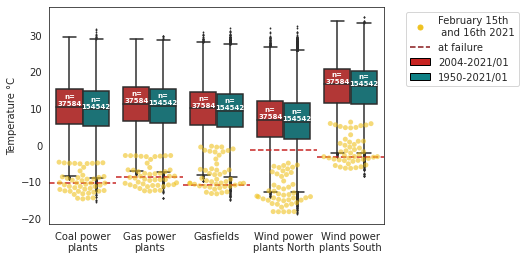

In [53]:
ax = sns.boxplot(data=temp_winter17_70wind,x='variable',y='value',hue='timespan',fliersize=1)

sns.swarmplot(data=temp_extFeb21wind,x='variable',y='value',color=COLORS[2],alpha=0.6,ax=ax)
ax.axhline(fail_temp.temp[0],0,0.2, ls='--')
ax.axhline(fail_temp.temp[1],0.2,0.4, ls='--')
ax.axhline(fail_temp.temp[2],0.4,0.6, ls='--')
ax.axhline(fail_temp_windN,0.6,0.8, ls='--')
ax.axhline(fail_temp_windS,0.8,1, ls='--')

legend_elements = [Line2D([0], [0], marker='o', color=COLORS[2], label='February 15th\n and 16th 2021',
                          markerfacecolor=COLORS[2], markersize=5,linewidth=0),
                   Line2D([0], [0], linestyle='--', color=COLORS[5], label='at failure',
                          markerfacecolor=COLORS[0], markersize=9),
                   Patch(facecolor=COLORS[0], edgecolor='black',
                         label='2004-2021/01'),
                  Patch(facecolor=COLORS[1], edgecolor='black',
                         label='1950-2021/01')]
lgd=ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')#loc='upper right')
plt.ylabel('Temperature °C')
plt.xlabel('')

medians1 = temp_winter17_70wind[temp_winter17_70wind.timespan=='17y'].groupby('variable').median().values
nobs1 = temp_winter17_70wind[temp_winter17_70wind.timespan=='17y'].groupby('variable').count().values[:,0]
medians2 = temp_winter17_70wind[temp_winter17_70wind.timespan=='71y'].groupby('variable').median().values
nobs2 = temp_winter17_70wind[temp_winter17_70wind.timespan=='71y'].groupby('variable').count().values[:,0]
 
# Add it to the plot
pos1 = range(len(nobs1))
for tick,label in zip(pos1,ax.get_xticklabels()):
    ax.text(pos1[tick]-0.2,
            medians1[tick] + 0.3,
            'n=\n'+str(nobs1[tick]),
            horizontalalignment='center',
            size='x-small',
            color='white',
            weight='semibold')
pos2 = range(len(nobs2))
for tick,label in zip(pos2,ax.get_xticklabels()):
    ax.text(pos2[tick]+0.2,
            medians2[tick] + 0.3,
            'n=\n'+str(nobs2[tick]),
            horizontalalignment='center',
            size='x-small',
            color='white',
            weight='semibold')


plt.savefig(fig_path + 'temp_gasfields_powerplants70y_wind.pdf',dpi=300,
           bbox_extra_artists=(lgd,), bbox_inches='tight')

In [66]:
# save data
temp_winter17_70wind.to_csv(fig_path_raw + 'FigA2_winter_temperatures.csv')
fail_temps = pd.concat([fail_temp,pd.DataFrame({'temp':[fail_temp_windN,fail_temp_windS],
                                                'type':['Wind power\nplants North','Wind power\nplants South']})],axis=0)
fail_temps.to_csv(fig_path_raw + 'FigA2_failure_temperatures.csv')

# define outage functions

## plot threshold functions

In [ ]:
t0 = (temppp.NG['2021-02']<=out_model_param.outage_temperature_threshold['gas']).idxmax()
t1 = (temppp.NG[t0:]>=out_model_param.recovery_temperature_threshold ['gas']).idxmax()
k = out_model_param.outage_capacity.gas/out_model_param.recovery_length.gas
max_out = round(float(out_model_param.outage_capacity['gas']),1)

(reduction.NG['2021-02']/1000).plot(label='outage GW')
t2 = t1 + np.timedelta64(int(round(max_out/k)),'h')
#plt.plot([t0,t1,t2],[max_out,max_out,0],color=COLORS[1],linewidth=1,label='approx. outage')
pd.Series([max_out,max_out,0],index=[t0,t1,t2]).plot(color=COLORS[1],linewidth=1,label='approx. outage')
plt.text(t2,5,'k='+str(round(k,3))+'GW/h',color=COLORS[1])
tempgf['2021-02-10':].plot(label='temp °C',color=COLORS[4])
plt.axvline(x=t0,ls='-',color=COLORS[2],linewidth=1,label='failure')
plt.legend(loc='lower right')
plt.title('GAS')
print('t0-t1:',(t1-t0)/np.timedelta64(1,'h'))
print('k:',round(k,3))
print('temp_thresh:',round(tempgf[t0],2))
print('max_out:',round(max_out,1))

tmin = reduction.NG['2021-02'].index[0]
tmax = reduction.NG['2021-02'].index[-1]
plt.hlines(0,tmin,tmax,color='black',lw=0.5)

plt.savefig(fig_path + 'thresh_gasPP.pdf',dpi=300)

In [ ]:
t0 = (tempwpNS.t2mNorth['2021-02-10':'2021-02-28']<=out_model_param.outage_temperature_threshold['wind_north']).idxmax()
t1 = (tempwpNS.t2mNorth[(t0+np.timedelta64(10,'h')):]>=out_model_param.recovery_temperature_threshold ['wind_north']).idxmax()
max_out = round(float(out_model_param.outage_capacity['wind_north']),1)
k = out_model_param.outage_capacity.wind_north/out_model_param.recovery_length.wind_north

t2 = t1 + np.timedelta64(int(round(max_out/k)),'h')
#(reduction.WIND['2021-02']/1000).plot(label='outage GW')
(reductionN.WIND['2021-02']/1000).plot(label='outage GW')
#plt.plot([t0,t1,t2],[max_out,max_out,0],color=COLORS[1],linewidth=1,label='approx. outage')
pd.Series([max_out,max_out,0],index=[t0,t1,t2]).plot(color=COLORS[1],linewidth=1,label='approx. outage')
plt.text(t2,5,'k='+str(round(k,3))+'GW/h',color=COLORS[1])
tempwpNS.t2mNorth['2021-02-10':].plot(label='temp °C',color=COLORS[4])
plt.axvline(x=t0,ls='-',color=COLORS[2],linewidth=1,label='failure')
plt.legend(loc='lower right')
plt.title('WIND N')

print('t0-t1:',(t1-t0)/np.timedelta64(1,'h'))
print('t1-t2:',(t2-t1)/np.timedelta64(1,'h'))
print('k:',round(k,3))
print('temp_thresh:',round(tempwpNS.t2mNorth[t0],2))
print('max_out:',round(max_out,1))

tmin = reductionN.WIND['2021-02'].index[0]
tmax = reductionN.WIND['2021-02'].index[-1]
plt.hlines(0,tmin,tmax,color='black',lw=0.5)

plt.savefig(fig_path + 'thresh_windN.pdf',dpi=300)

In [ ]:
t0 = (tempwpNS.t2mSouth['2021-02-10':'2021-02-28']<=out_model_param.outage_temperature_threshold['wind_south']).idxmax()
t1 = (tempwpNS.t2mSouth[(t0+np.timedelta64(10,'h')):]>=out_model_param.recovery_temperature_threshold ['wind_south']).idxmax()
max_out = round(float(out_model_param.outage_capacity['wind_south']),1)
k = out_model_param.outage_capacity.wind_south/out_model_param.recovery_length.wind_south

t2 = t1 + np.timedelta64(int(round(max_out/k)),'h')
(reductionS.WIND['2021-02']/1000).plot(label='outage GW')
#plt.plot([t0,t1,t2],[max_out,max_out,0],color=COLORS[1],linewidth=1,label='approx. outage')
pd.Series([max_out,max_out,0],index=[t0,t1,t2]).plot(color=COLORS[1],linewidth=1,label='approx. outage')
plt.text(t2,20,'k='+str(round(k,3))+'GW/h',color=COLORS[1])
tempwpNS.t2mSouth['2021-02-10':].plot(label='temp °C',color=COLORS[4])
plt.axvline(x=t0,ls='-',color=COLORS[2],linewidth=1,label='failure')
plt.legend(loc='lower right')
plt.title('WIND S')

print('t0-t1:',(t1-t0)/np.timedelta64(1,'h'))
print('t1-t2:',(t2-t1)/np.timedelta64(1,'h'))
print('k:',round(k,3))
print('temp_thresh:',round(tempwpNS.t2mSouth[t0],2))
print('max_out:',round(max_out,1))

tmin = reductionS.WIND['2021-02'].index[0]
tmax = reductionS.WIND['2021-02'].index[-1]
plt.hlines(0,tmin,tmax,color='black',lw=0.5)

plt.savefig(fig_path + 'thresh_windS.pdf',dpi=300)

In [ ]:
t0 = (temppp.COAL['2021-02']<=out_model_param.outage_temperature_threshold['coal']).idxmax()
t1 = (temppp.COAL[t0:]>=out_model_param.recovery_temperature_threshold ['coal']).idxmax()
max_out = round(float(out_model_param.outage_capacity['coal']),1)
k = out_model_param.outage_capacity.coal/out_model_param.recovery_length.coal

t2 = t1 + np.timedelta64(int(round(max_out/k)),'h')
(reduction.COAL['2021-02']/1000).plot(label='outage GW')
#plt.plot([t0,t1,t2],[max_out,max_out,0],color=COLORS[1],linewidth=1,label='approx. outage')
pd.Series([max_out,max_out,0],index=[t0,t1,t2]).plot(color=COLORS[1],linewidth=1,label='approx. outage')
plt.text(t2,2,'k='+str(round(k,3))+'GW/h',color=COLORS[1])
temppp.COAL['2021-02-10':].plot(label='temp °C',color=COLORS[4])
plt.axvline(x=t0,ls='-',color=COLORS[2],linewidth=1,label='failure')
plt.legend(loc='lower right')
plt.title('COAL')

print('t0-t1:',(t1-t0)/np.timedelta64(1,'h'))
print('k:',round(k,3))
print('temp_thresh:',round(temppp.COAL[t0],2))
print('max_out:',round(max_out,1))

tmin = reductionS.WIND['2021-02'].index[0]
tmax = reductionS.WIND['2021-02'].index[-1]
plt.hlines(0,tmin,tmax,color='black',lw=0.5)

plt.savefig(fig_path + 'thresh_coal.pdf',dpi=300)

## get threshold functions

In [65]:
def get_thresh_monthly(temp,temp_fail,temp_recover,cap_loss,k):
    available_cap = pd.Series(0,index=temp.index)
    below_thresh = temp[temp<temp_fail].resample('M').count().replace(0,np.nan).dropna()
    h_recovery = int(-cap_loss/k)
    for i in range(len(below_thresh)):
        ym = below_thresh.index.strftime("%Y-%m")[i]
        t0 = (temp[ym]<temp_fail).idxmax()
        t1 = (temp[(t0+np.timedelta64(10,'h')):]>temp_recover).idxmax()
        const_time = int((t1-t0)/np.timedelta64(1,'h'))
        t2 = t1 + np.timedelta64(h_recovery-1,'h')
        available_cap[t0:t2] = cap_loss + k*np.concatenate([np.array([0]*const_time),np.arange(h_recovery)])[:len(available_cap[t0:t2])]
    return(available_cap)

make a second threshold function which iterates over each occurrence of temperatures below threshold

after getting t1 of one threshold, search for next

In [66]:
def get_thresh(temp,temp_fail,temp_recover,cap_loss,k):
    available_cap = pd.Series(0,index=temp.index)
    below_thresh = temp[temp<temp_fail].resample('M').count().replace(0,np.nan).dropna()
    ym = below_thresh.index.strftime("%Y-%m")
    h_recovery = int(-cap_loss/k)
    for i in range(len(below_thresh)):
        t1 = pd.to_datetime(ym[i])
        while(t1.strftime("%Y-%m")==ym[i]):
            t0 = (temp[t1:]<temp_fail).idxmax()
            t1 = (temp[(t0+np.timedelta64(10,'h')):]>temp_recover).idxmax()
            const_time = int((t1-t0)/np.timedelta64(1,'h'))
            t2 = t1 + np.timedelta64(h_recovery-1,'h')
            available_cap[t0:t2] = cap_loss + k*np.concatenate([np.array([0]*const_time),np.arange(h_recovery)])[:len(available_cap[t0:t2])]
            if sum(temp[t1:]<temp_fail)==0:
                break
    return(available_cap)

In [67]:
temp = temppp.COAL
temp_fail = out_model_param.outage_temperature_threshold.coal
temp_recover = out_model_param.recovery_temperature_threshold.coal
cap_loss = out_model_param.outage_capacity.coal
k = -out_model_param.outage_capacity.coal/out_model_param.recovery_length.coal


thresh_coal = get_thresh(temp,temp_fail,temp_recover,cap_loss,k)

In [68]:
temp = tempgf
temp_fail = out_model_param.outage_temperature_threshold.gas_gasfield_temperatures
temp_recover = out_model_param.recovery_temperature_threshold.gas_gasfield_temperatures
cap_loss = out_model_param.outage_capacity.gas_gasfield_temperatures
k = -out_model_param.outage_capacity.gas_gasfield_temperatures/out_model_param.recovery_length.gas_gasfield_temperatures

thresh_gas = get_thresh(temp,temp_fail,temp_recover,cap_loss,k)

In [69]:
temp = temppp.NG
temp_fail = out_model_param.outage_temperature_threshold.gas
temp_recover = out_model_param.recovery_temperature_threshold.gas
cap_loss = out_model_param.outage_capacity.gas
k = -out_model_param.outage_capacity.gas/out_model_param.recovery_length.gas

thresh_gasPP = get_thresh(temp,temp_fail,temp_recover,cap_loss,k)

In [70]:
temp = tempwpNS.t2mNorth
temp_fail = out_model_param.outage_temperature_threshold.wind_north
temp_recover = out_model_param.recovery_temperature_threshold.wind_north
cap_loss = out_model_param.outage_capacity.wind_north
k = -out_model_param.outage_capacity.wind_north/out_model_param.recovery_length.wind_north

thresh_windN = get_thresh(temp,temp_fail,temp_recover,cap_loss,k)

In [71]:
temp = tempwpNS.t2mSouth
temp_fail = out_model_param.outage_temperature_threshold.wind_south
temp_recover = out_model_param.recovery_temperature_threshold.wind_south
cap_loss = out_model_param.outage_capacity.wind_south
k = -out_model_param.outage_capacity.wind_south/out_model_param.recovery_length.wind_south

thresh_windS = get_thresh(temp,temp_fail,temp_recover,cap_loss,k)

62GW thermal resources according to SARA report - error- add some more

In [72]:
thresh_gas_coal = 62 + added_thermal_cap - (thresh_gas + thresh_coal)

In [73]:
thresh_gas_coalPP = 62 + added_thermal_cap - (thresh_gasPP + thresh_coal)

wind outages are subtracted from wind power generation

total installed cap wind: 33GW
-> calculate share of wind reduction

In [74]:
wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33

In [75]:
thresh_total = thresh_gas_coal + wp_remain

In [76]:
thresh_totalPP = thresh_gas_coalPP + wp_remain

In [80]:
thresh_gas.to_csv(tx_path + 'thresholds/threshold_gas.csv',header=False)
thresh_gasPP.to_csv(tx_path + 'thresholds/threshold_gasPP.csv',header=False)
thresh_coal.to_csv(tx_path + 'thresholds/threshold_coal.csv',header=False)
thresh_gas_coal.to_csv(tx_path + 'thresholds/threshold_gas_coal63.5GW.csv',header=False)
thresh_gas_coalPP.to_csv(tx_path + 'thresholds/threshold_gas_coalPP63.5GW.csv',header=False)
thresh_total.to_csv(tx_path + 'thresholds/thresh_total63.5GW.csv',header='thresh')
thresh_totalPP.to_csv(tx_path + 'thresholds/thresh_totalPP63.5GW.csv',header='thresh')

### expected deficit for 71 years with and  without 2021

In [81]:
thresh_totalPP = pd.read_csv(tx_path + 'thresholds/thresh_totalPP63.5GW.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')['0']

gas power plant temperatures

In [82]:
bef2021 = round((load70.load_est/1000 - thresh_totalPP)[(load70.load_est/1000 - thresh_totalPP)>0][:'2020'].sum()/1000,2)
with2021 = round((load70.load_est/1000 - thresh_totalPP)[(load70.load_est/1000 - thresh_totalPP)>0].sum()/1000,2)
only2021 = round((load70.load_est/1000 - thresh_totalPP)[(load70.load_est/1000 - thresh_totalPP)>0]['2021-02'].sum()/1000,2)
numevents = len((load70.load_est/1000 - thresh_totalPP)[(load70.load_est/1000 - thresh_totalPP)>0].resample('M').count().replace(0,np.nan).dropna())
print('number of events',numevents)
print('sum outages',with2021,'TWh')
print('sum outages before 2021',bef2021,'TWh')
print('sum outages 2021',only2021,'TWh')

number of events 26
sum outages 7.66 TWh
sum outages before 2021 6.17 TWh
sum outages 2021 1.49 TWh
